In [1]:
import pandas as pd
import re
import sklearn as sk
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# file management
import os
import sys

# NLP
import nltk
from nltk.corpus import stopwords
nltk.download('wordnet')
nltk.download('stopwords')
import gensim
import gensim.downloader as gdownload

# deep learning
import tensorflow as tf
import keras
from tensorflow.keras import layers
print(tf.config.list_physical_devices('GPU')) # check if gpu is detected
from keras import backend as K

# visualization
import matplotlib.pyplot as plt
# tensorboard
%load_ext tensorboard
from pprint import pprint

[nltk_data] Downloading package wordnet to /home/ashkan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/ashkan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
2023-08-12 13:37:34.010962: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-12 13:37:34.132221: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-12 13:37:35.016886: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2023-08-12 13:37:35.918669: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-12 13:37:36.098562: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-12 13:37:36.098623: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [2]:
# preprocessing following paper

# 1)lowercase

# 2)tokenization

# 3)remove non-ascii tokens

# 4)rmeove punctuation

# 5)remove non-alpha-numeric characters

# 6)sub digits with words --> useless. I'll just change them to "NUM"

# 7)remove stopwords (NLTK)

# 8)lemmatization (NLTK)

In [3]:
# hyperparameters 
# VOCAB_SIZE = 10000
MAX_TWEET_WORDS = 60 # max words in a 280 letter tweet is 180, but I'll bring it down manually
# BATCH_SIZE = 64

In [4]:
# import data
df = pd.read_csv('./cybertweets/annotated.csv')
df = df.drop(['id'], axis = 1)
print("total data:", len(df))
print(df.head(10))
print('annotations: ', df['annotation'].unique())

total data: 21368
                                                text  annotation  \
0  Best way to build empathy is through honesty a...  irrelevant   
1  Cryptocurrency Scams Replacing Ransomware as A...    business   
2  Cryptocurrency Scams Replacing Ransomware as A...    business   
3  Protect  your customers  access Prestashop Ant...      threat   
4  Data leak from Huazhu Hotels may affect 130 mi...      threat   
5  Instagram App 41.1788.50991.0 #Denial Of #Serv...      threat   
6  (good slides): \n\nThe Advanced Exploitation o...      threat   
7  CVE-2018-1000532 (beep)\nhttps://t.co/CaKbo38U...      threat   
8  Will upload some of yesterday's videos which d...      threat   
9  Well you still protect them Ransomware Offline...    business   

                type  
0  ['Vulnerability']  
1     ['ransomware']  
2     ['ransomware']  
3           ['Ddos']  
4           ['leak']  
5        ['General']  
6  ['vulnerability']  
7  ['vulnerability']  
8           ['ddos']  
9  

In [5]:
# preprocessing functions

def text_preprocessing(tweets_list, embedding):
    set_stopwords = set(stopwords.words('english'))

    processed_tweets = []
    for i, txt in enumerate(tweets_list):        
        # replace stuff
        txt = re.sub('\b\S*[\x80-\xFF]\S*\b', '', txt) # any words with non-ascii characters
        txt = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', 'URL', txt) # urls
        txt = re.sub('(?<!\S)@([A-Za-z0-9_]+)(?!\S)', 'USER', txt) # usernames
        # txt = re.sub('#\w+', 'HASHTAG', txt) # hashtags
        txt = re.sub('#', '', txt) # hastags --> just remove the tag
        txt = re.sub('\b\d+\b', 'NUM', txt) # numbers
        txt = re.sub('[^\w\s]', '', txt) # punctuation
        
        # lowercase
        txt = txt.lower()

        # https://saturncloud.io/blog/reshaping-text-data-for-lstm-models-in-keras-a-comprehensive-guide/

        # split
        # nltk handles all punctuation as features
        word_arr = re.split(f'\s+', txt) # returns list of words
    
        # remove stopwords and drop empty strings
        word_arr = [word for word in word_arr if word not in set_stopwords and len(word) != 0]
        
        # lemmatize
        lemmatizer = nltk.stem.WordNetLemmatizer()
        word_arr = [lemmatizer.lemmatize(word) for word in word_arr]

        if i % 10000 == 0: # log the processed message in specified intervals
            print(f"Processed text #{i}:", word_arr)
            print("---------------------------")

        processed_tweets.append(word_arr)

    # DEBUG
    # print("processed tweets:", processed_tweets[:10])
    
    # TODO: handle this with preprocessed embedding
    # tokenize (I ditched the old tokenizer)
    print("tokenizing...")
    embedding_length = len(embedding)
    # convert each word to its index. if it doesn't exist, set it to the last index. I don't care that it ruins one word's meaning
    tokenized = [[embedding.key_to_index[word] if word in embedding else (embedding_length - 1) for word in split_sentence] for split_sentence in processed_tweets]

    # add padding and convert to numpy array
    print('padding sequences...')
    tokenized = np.asarray(keras.preprocessing.sequence.pad_sequences(
            tokenized,
            padding = 'post',
            maxlen = MAX_TWEET_WORDS,
    ))

    # DEBUG
    print(tokenized)
    print('feature vector shape:', tokenized.shape)

    return tokenized

# preprocess annotations for initial binary classification
def annotation_preprocessing(annotation_list):
    # set all "threat" to 1, the rest to 0
    return np.asarray([1 if x == "threat" else 0 for x in annotation_list])

def train_valid_test_split(ds, train_ratio, valid_ratio, batch_size):
    train_ratio = 0.8
    valid_ratio = 0.1
    init_len = len(ds)
    num_train = np.floor(init_len * train_ratio)
    num_valid = np.floor(init_len * valid_ratio)

    train_ds = ds.take(num_train).batch(batch_size)
    valid_ds = ds.skip(num_train).take(num_valid).batch(batch_size)
    test_ds = ds.skip(num_train).skip(num_valid).batch(batch_size)
    
    print(f'train ds has {num_train} items in {len(train_ds)} batches.')
    print(f'valid ds has {num_valid} items in {len(valid_ds)} batches.')
    print(f'test ds has {init_len - num_train - num_valid} items in {len(test_ds)} batches.')

    return (train_ds, valid_ds, test_ds)

def train_and_evaluate(model, train_ds, valid_ds, test_ds, epochs, optimizer, loss):
    model.compile(
        loss = loss,
        optimizer = optimizer,
        metrics = ['acc'],
    )

    print(model.summary())
    history = model.fit(
        train_ds,
        validation_data = valid_ds,
        epochs = epochs,
    )

    # plot losses over time --> shown after training
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Accuracy')
    plt.xlabel('epoch')
    plt.xlabel('accuracy')
    plt.legend(['train','val'], loc='upper left')
    plt.grid()
    plt.ylim(0.5, 1)
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Loss')
    plt.xlabel('epoch')
    plt.xlabel('loss')
    plt.legend(['train','val'], loc='upper left')
    plt.grid()
    plt.show()

    # evaluate
    model.evaluate(test_ds)

def tokenize_types(unique_types):
    index_to_type = {index: value for index, value in zip(range(len(unique_types)), unique_types)}
    type_to_index = {value: index for index, value in index_to_type.items()}
    return (index_to_type, type_to_index)

def types_preprocessing(typescol):
    # notes: 
    # I'll just use the first vulnerability type 
    # If the type is "all", I'll drop it from the input

    processed = []
    for string in typescol:
        # print(string)
        string = string.lower() # lowercase
        string = re.sub(r"[,\[\]']", " ", string) # replace [, ], and ' with space
        strlist = string.split() # split list by space
        if 'all' in strlist: strlist.remove('all') # remove the "all" type
        one_type = strlist[0] if len(strlist) > 0 else "empty" # select just the first type

        processed.append(one_type)

    index_to_type, type_to_index = tokenize_types(set(processed))
    # print(type_to_index.items()) # DEBUG

    for i in range(len(processed)):
        processed[i] = type_to_index[processed[i]] # convert each type to index

    return (index_to_type, type_to_index, np.asarray(processed))

def shuffle(nparr, random_state = 42):
    rng = np.random.RandomState(random_state) # reset the seed
    return rng.permutation(nparr)

In [6]:
# actual preprocessing
# embedding = gdownload.load('glove-wiki-gigaword-100') # pretrained embedding --> much cleaner than twitter stuff
# embedding = gdownload.load('glove-twitter-200') # pretrained embedding --> much cleaner than twitter stuff
embedding = gdownload.load('glove-twitter-50') # pretrained embedding --> much cleaner than twitter stuff
original_texts = np.asarray(df['text']) # I'll use this to check the preprocessing process

tokenized_texts = text_preprocessing(df['text'], embedding) # TEMP
annotation_labels = annotation_preprocessing(df['annotation'])
index_to_type, type_to_index, type_labels = types_preprocessing(df['type'])

# shuffle the data
original_texts = shuffle(original_texts) # debug
tokenized_texts = shuffle(tokenized_texts)
annotation_labels = shuffle(annotation_labels)
type_labels = shuffle(type_labels)

# reduce data for faster training # REMOVE LATER
ratio_keep = 1 # was 0.2
original_texts = original_texts[:int(len(original_texts) * ratio_keep)] # debug
tokenized_texts = tokenized_texts[:int(len(tokenized_texts) * ratio_keep)]
annotation_labels = annotation_labels[:int(len(annotation_labels) * ratio_keep)]
type_labels = type_labels[:int(len(type_labels) * ratio_keep)]

# DEBUG
# def print_list(title, list):
#     print(title)
#     for i, x in enumerate(list):
#         print(f'<<{i}>>', x)
#     print("------------------------------------------")

# sample_length = 10
# print_list("original data:", original_data[:sample_length])
# tokenized_input_sample = [[index for index in x] for x in tokenized_texts][:sample_length]
# print_list("split input: ", [[embedding.index_to_key[index] for index in example] for example in tokenized_input_sample])
# print_list("tokenized input: ", tokenized_input_sample)
# print("labels: ", annotation_labels[:sample_length])

# create model 1 datasets
model1_ds = tf.data.Dataset.from_tensor_slices((tokenized_texts, annotation_labels))
model1_train, model1_valid, model1_test = train_valid_test_split(model1_ds, 0.8, 0.1, 32) # was 1

# create model 2 datasets
model2_ds = tf.data.Dataset.from_tensor_slices((tokenized_texts, type_labels)) # create tf dataset
model2_train, model2_valid, model2_test = train_valid_test_split(model2_ds, 0.8, 0.1, 32) # split dataset

Processed text #0: ['best', 'way', 'build', 'empathy', 'honesty', 'vulnerability']
---------------------------
Processed text #10000: ['leader', 'ddosforhire', 'gang', 'pleads', 'guilty', 'bomb', 'threat', 'url', 'url']
---------------------------
Processed text #20000: ['another', 'example', 'vulnerability', 'like', 'strut', 'effect', 'data', 'integrity', 'pii', 'protection', 'url']
---------------------------
tokenizing...
padding sequences...
[[   209    271   4048 ...      0      0      0]
 [351677  21317  31757 ...      0      0      0]
 [351677  21317  31757 ...      0      0      0]
 ...
 [   183    538  36508 ...      0      0      0]
 [  3920   3920    844 ...      0      0      0]
 [  3920    200  88973 ...      0      0      0]]
feature vector shape: (21368, 60)


2023-08-12 13:38:15.657721: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


train ds has 17094.0 items in 535 batches.
valid ds has 2136.0 items in 67 batches.
test ds has 2138.0 items in 67 batches.
train ds has 17094.0 items in 535 batches.
valid ds has 2136.0 items in 67 batches.
test ds has 2138.0 items in 67 batches.


2023-08-12 13:38:15.657915: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-12 13:38:15.657948: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-12 13:38:17.297689: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-12 13:38:17.297816: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-12 13:38:17.297827: I tensorflow/core/co

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 60, 50)            59675700  
                                                                 
 batch_normalization (Batch  (None, 60, 50)            200       
 Normalization)                                                  
                                                                 
 bidirectional (Bidirection  (None, 120)               40320     
 al)                                                             
                                                                 
 dense (Dense)               (None, 32)                3872      
                                                                 
 dense_1 (Dense)             (None, 8)                 264       
                                                                 
 dense_2 (Dense)             (None, 1)                 9

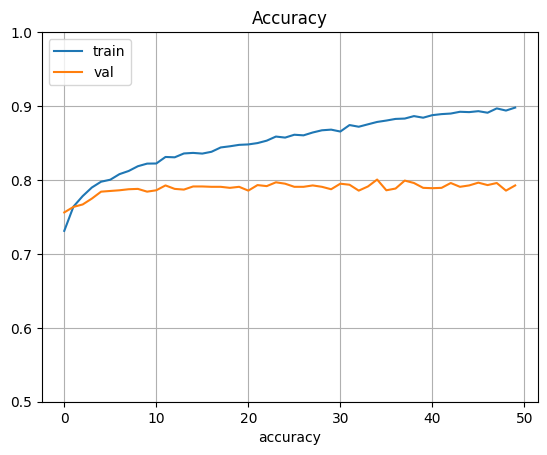

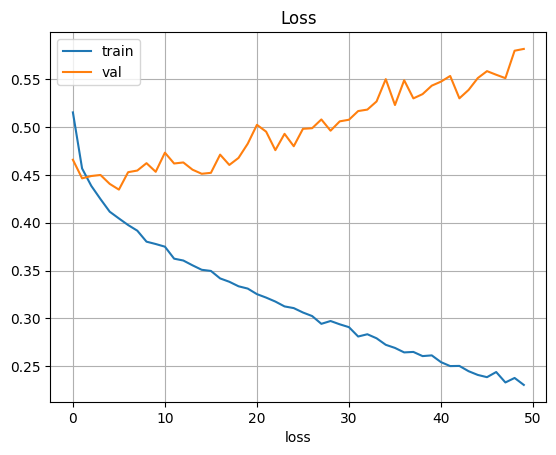

67/67 [==============================] - 1s 18ms/step - loss: 0.5325 - acc: 0.7970


In [8]:
### model 1: binary classification of relevant vs non-relevant ###

K.clear_session() # not sure if this even works

# classification model
def pretrained_embedding(embedding):
    # note: embedding is declared in the previous cell
    
    vocab_size = len(embedding)
    embedding_vector_size = len(embedding[embedding.index_to_key[0]])

    # create embedding matrix
    embedding_matrix = np.zeros((vocab_size, embedding_vector_size))
    # iterate through embedding and copy word vectors as weights
    for i in range(vocab_size):
        embedding_matrix[i, :] = embedding[embedding.index_to_key[i]]

    embedding_layer = layers.Embedding(input_dim = vocab_size, output_dim = embedding_vector_size, trainable = False)
    embedding_layer.build((None,)) # I have no idea why I should do this
    embedding_layer.set_weights([embedding_matrix]) # square brackets are because some layers take multiple types of weights
    
    return embedding_layer

# GRU model
# for optimization, see https://stackoverflow.com/questions/48714407/rnn-regularization-which-component-to-regularize
model1 = keras.Sequential([
    layers.Input(shape = (MAX_TWEET_WORDS,)),
    pretrained_embedding(embedding),
    # layers.GRU(MAX_TWEET_WORDS, return_sequences=True), # not a difference
    layers.BatchNormalization(),
    layers.Bidirectional(
        layers.GRU(
            MAX_TWEET_WORDS,
            dropout = 0.2,
        ),
    ),

    layers.Dense(32, activation = 'relu'),
    layers.Dense(8, activation = 'relu'),
    layers.Dense(1, activation = 'sigmoid'),
])
train_and_evaluate(
    model1,
    model1_train,
    model1_valid,
    model1_test,
    epochs = 50,
    loss = keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(learning_rate = 0.001),
)

In [9]:
# # phase 2: multiclass classification for vulnerability type detection

# # utils

# ### preprocessing ###
# # load data
# df2 = pd.read_csv('./cybertweets/annotated.csv')
# df2 = df2.drop(['id'], axis = 1)
# print(df2.head())
# print(len(df2))
# print('types:')
# for unique_type in df2['type'].unique():
#     print(type(unique_type), unique_type)

# # select one type of vulnerability for every item
# df2['type'] = df2['type'].apply(lambda x: preprocess_types(x)) # preprocess types for each input
# df2 = df2[df2['type'] != 'empty'] # remove row if type is "empty"
# unique_types = df2['type'].unique()
# print("uniques types: ", unique_types)

# # tokenize types
# index_to_type, type_to_index = tokenize_types(unique_types)
# df2['type'] = df2['type'].apply(lambda x: type_to_index[x])
# print(df2['type'].unique())

# # create tf datasets
# data = np.asarray(df2['text'])
# labels = np.asarray(df2['type'])
# rng = np.random.RandomState(42) # set random state
# data = rng.permutation(data) # shuffle texts
# rng = np.random.RandomState(42) # reset random state
# labels = rng.permutation(labels) # shuffle labels
# model2_ds = tf.data.Dataset.from_tensor_slices((data, labels)) # create tf dataset
# model2_train, model2_valid, model2_test = train_valid_test_split(model2_ds, 0.8, 0.1, 32) # split dataset

# # notes: 
# # I'll just use the first vulnerability type 
# # If the type is "all", I'll drop it from the input

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 60, 50)            59675700  
                                                                 
 batch_normalization (Batch  (None, 60, 50)            200       
 Normalization)                                                  
                                                                 
 bidirectional (Bidirection  (None, 120)               40320     
 al)                                                             
                                                                 
 dense (Dense)               (None, 32)                3872      
                                                                 
 dense_1 (Dense)             (None, 8)                 264       
                                                                 
Total params: 59720356 (227.82 MB)
Trainable params: 445

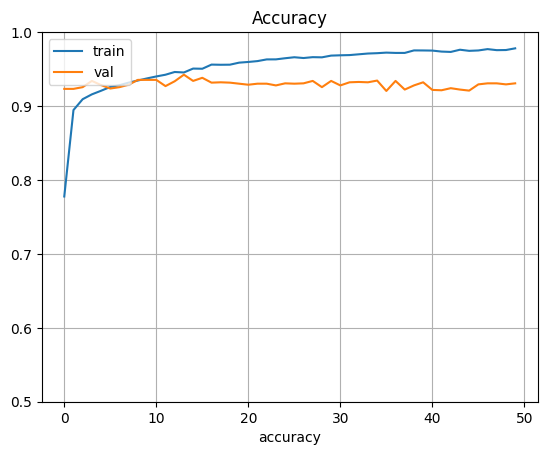

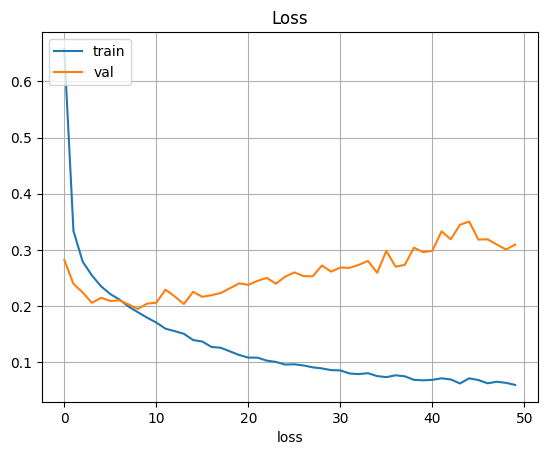

67/67 [==============================] - 1s 17ms/step - loss: 0.3541 - acc: 0.9200


In [12]:
### model 2: multiclass classification of vulnerability types ###

K.clear_session() # not sure if this even works

# classification model
def pretrained_embedding(embedding):
    # note: embedding is declared in the previous cell
    
    vocab_size = len(embedding)
    embedding_vector_size = len(embedding[embedding.index_to_key[0]])

    # create embedding matrix
    embedding_matrix = np.zeros((vocab_size, embedding_vector_size))
    # iterate through embedding and copy word vectors as weights
    for i in range(vocab_size):
        embedding_matrix[i, :] = embedding[embedding.index_to_key[i]]

    embedding_layer = layers.Embedding(input_dim = vocab_size, output_dim = embedding_vector_size, trainable = False)
    embedding_layer.build((None,)) # I have no idea why I should do this
    embedding_layer.set_weights([embedding_matrix]) # square brackets are because some layers take multiple types of weights
    
    return embedding_layer

# GRU model
# for optimization, see https://stackoverflow.com/questions/48714407/rnn-regularization-which-component-to-regularize
model2 = keras.Sequential([
    layers.Input(shape = (MAX_TWEET_WORDS,)),
    pretrained_embedding(embedding),
    layers.BatchNormalization(),
    layers.Bidirectional(
        layers.GRU(
            MAX_TWEET_WORDS,
            dropout = 0.2,
        ),
    ),

    layers.Dense(32, activation = 'relu'),
    layers.Dense(len(index_to_type), activation = 'softmax'), # index_to_type was declared before
])
train_and_evaluate(
    model2,
    model2_train,
    model2_valid,
    model2_test,
    epochs = 50,
    loss = keras.losses.SparseCategoricalCrossentropy(),
    optimizer = keras.optimizers.Nadam(),
)